In [1]:
import pandas as pd
from pandas_datareader import data as pdr
from datetime import datetime
import yfinance as yf
import quandl
import torch

In [2]:
# yf.pdr_override() # <== that's all it takes :-)

# Replace 'AAPL' with the stock symbol you're interested in
stock_symbol = 'SPY'

# # Define the time period for historical data
# start_date = datetime(2019, 1, 1)
# end_date = datetime(2022, 1, 1)

# # download dataframe
# data = pdr.get_data_yahoo(stock_symbol, start=start_date, end=end_date)

# # Display the first few rows
# data.head()

# data.to_csv('SPY.csv')

data = pd.read_csv('SPY.csv')

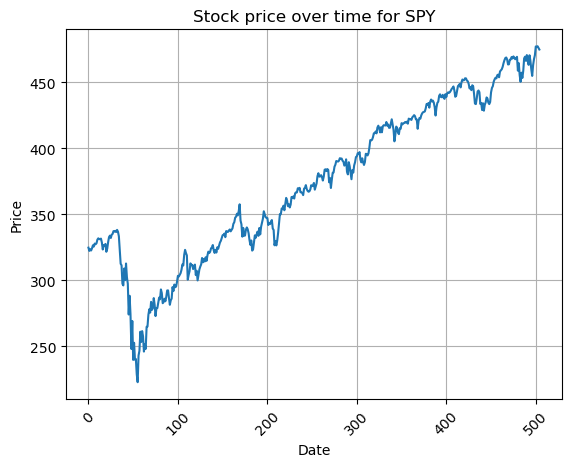

In [3]:
# plot the close prices

import matplotlib.pyplot as plt

plt.plot(data['Close'])
plt.title(f'Stock price over time for {stock_symbol}')
plt.ylabel('Price')
plt.xlabel('Date')
# rotate the x-axis dates
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


## Moving Average just to analyse the price

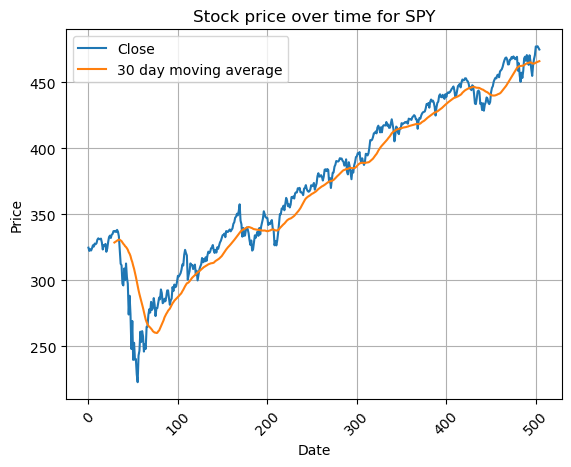

In [4]:
WINDOW_SIZE = 30  
data['moving_average'] = data['Close'].rolling(window=WINDOW_SIZE).mean()

plt.plot(data['Close'], label='Close')
plt.plot(data['moving_average'], label=f'{WINDOW_SIZE} day moving average')
plt.title(f'Stock price over time for {stock_symbol}')
plt.ylabel('Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.show()

## Implement DQNetwork

cuda
Creating Agent ...
... agent Created


  0%|          | 0/300 [00:00<?, ?it/s]

Episode reward: 184.8648485291974
Episode reward: 298.9028728439598
Episode reward: 61.41270957284769
Episode reward: 237.92047287371156
Episode reward: 549.375577439926
Episode reward: 95.3060554369356
Episode reward: 303.61380695278444
Episode reward: 160.15130183386077
Episode reward: 64.20424065818224
Episode reward: 262.4090790740886
Episode reward: 391.4157246310722
Episode reward: 254.02672754517198
Episode reward: 403.14994548750064
Episode reward: 359.94442502399124
Episode reward: 45.70735494517271
Episode reward: 193.4032888857273
Episode reward: 372.6285838689723
Episode reward: 42.59899213659719
Episode reward: 429.24646115957785
Episode reward: 193.42526358048417
Episode reward: 152.055033685313
Episode reward: -88.8500803716837
Episode reward: 499.62705408582406
Episode reward: 281.13172437141156
Episode reward: 390.70891310656225
Episode reward: 162.65013617732347
Episode reward: 314.64996855988784
Episode reward: -54.70910302721427
Episode reward: 175.1024247192172
Epi

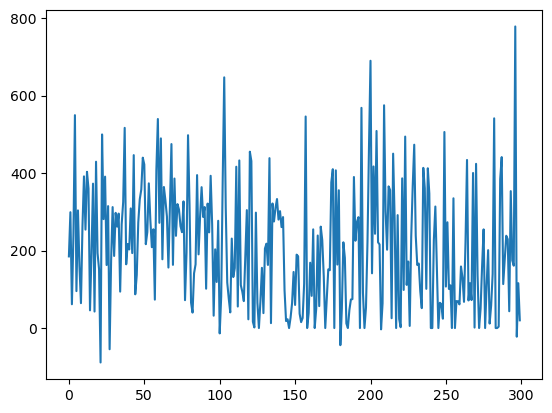

In [5]:
from utils.agent import Agent
from utils.env import SimplifiedStockTradingEnv
from utils.dqn import DQN
from utils.replay_buffer import ReplayBuffer
from utils.epsilon_greedy import EpsilonGreedy
from utils.lr_scheduler import MinimumExponentialLR

# Parameters
T = 20
price_list_size = T+1
sync_period=30
lr = 0.005
rb = 2000
es = 0.82
em = 0.013
ed = 0.9675
num_episodes=300
gamma=0.9
batch_size=128
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
# device = 'cpu'
print(device)

model = DQN(price_list_size, 1, 1, device).to(device)
target_model = DQN(price_list_size, 1, 1, device).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, amsgrad=True)
#lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
loss_fn = torch.nn.MSELoss()

replay_buffer = ReplayBuffer(rb)
env = SimplifiedStockTradingEnv(data, T=T)
epsilon_greedy = EpsilonGreedy(epsilon_start=es, epsilon_min=em, epsilon_decay=ed, env=env, model=model)
print("Creating Agent ...")
agent = Agent(env, model, target_model, sync_period, optimizer, lr_scheduler, loss_fn, replay_buffer, epsilon_greedy)
print("... agent Created")

episode_reward_list = agent.train(num_episodes, gamma, batch_size)
plt.plot(episode_reward_list)
plt.show()


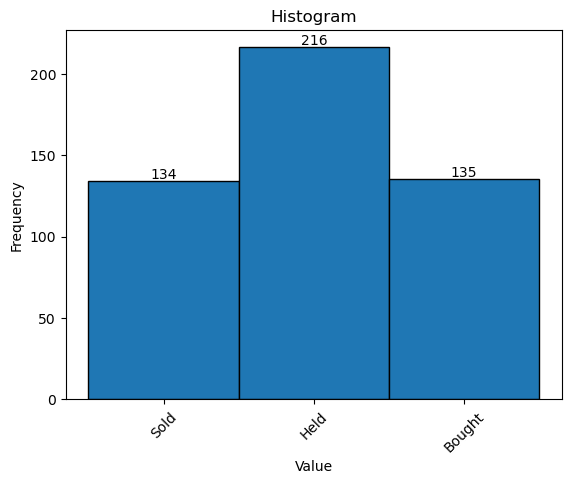

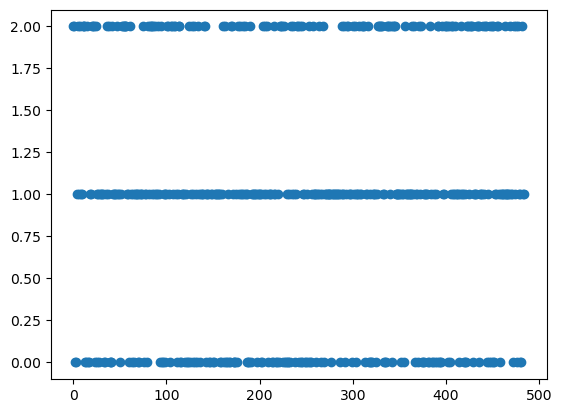

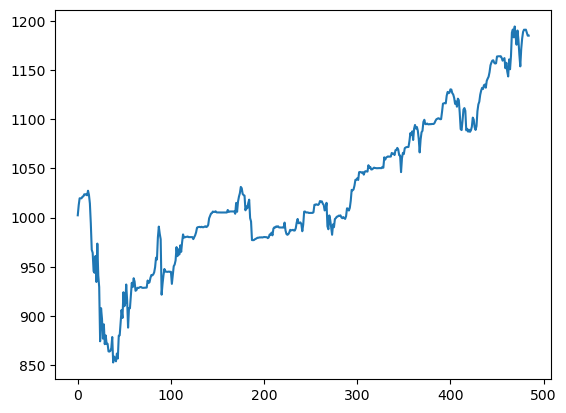

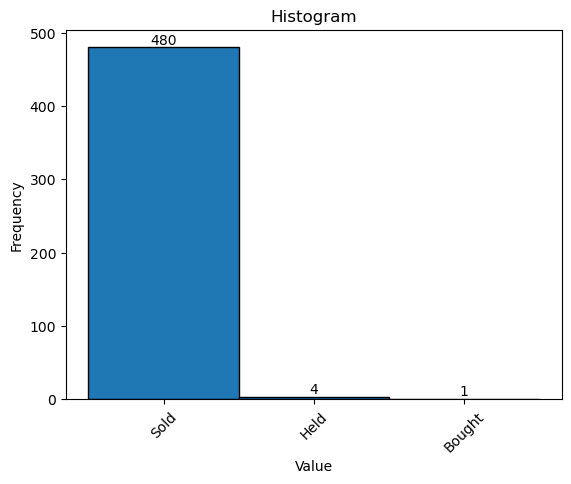

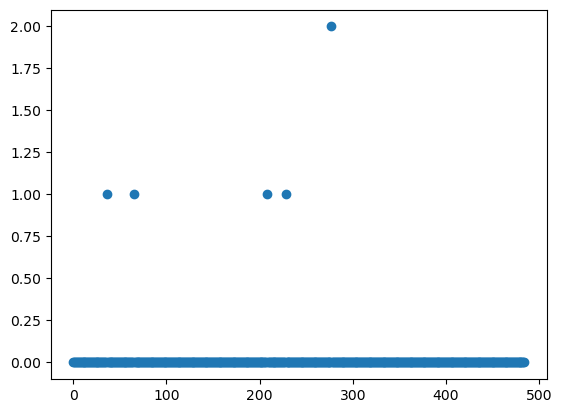

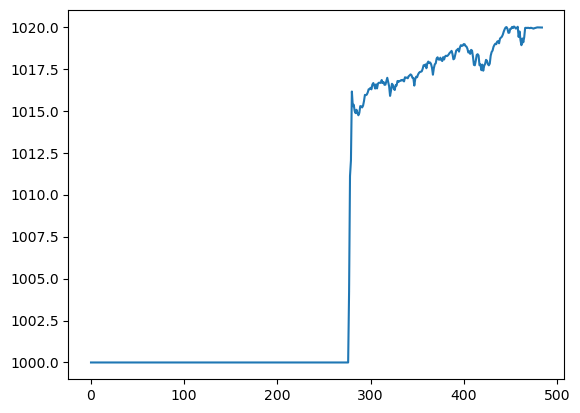

In [10]:
import numpy as np

num_bins = 3
bin_edges = np.linspace(min(agent.action_list[0]), max(agent.action_list[0]), num_bins + 1)
hist, _ = np.histogram(agent.action_list[0], bins=bin_edges)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.bar(bin_centers, hist, width=np.diff(bin_edges), align='center', edgecolor='black')
plt.xticks(bin_centers, ['Sold', 'Held', 'Bought'], rotation=45)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
for i in range(len(hist)):
    plt.text(bin_centers[i], hist[i], str(int(hist[i])), ha='center', va='bottom')
plt.show()
plt.scatter(range(len(agent.action_list[0])), agent.action_list[0])
plt.show()
plt.plot(agent.wealth_list[0])
plt.show()
bin_edges = np.linspace(min(agent.action_list[-1]), max(agent.action_list[-1]), num_bins + 1)
hist, _ = np.histogram(agent.action_list[-1], bins=bin_edges)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.bar(bin_centers, hist, width=np.diff(bin_edges), align='center', edgecolor='black')
plt.xticks(bin_centers, ['Sold', 'Held', 'Bought'], rotation=45)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
for i in range(len(hist)):
    plt.text(bin_centers[i], hist[i], str(int(hist[i])), ha='center', va='bottom')
plt.show()
plt.scatter(range(len(agent.action_list[-1])), agent.action_list[-1])
plt.show()
plt.plot(agent.wealth_list[-1])
plt.show()